<a href="https://colab.research.google.com/github/Ssurf777/U-Net_pipe_flow/blob/main/04_Inverse_PINNs_TVD_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 PINN vs Inverse PINN（1D Burgers方程式）

---

## ✅ Burgers方程式（1D）

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

- $u(x, t)$：速度  
- $\nu$：粘性係数（拡散率）

---

## 🔷 通常の PINN（Forward問題）

### 🎯 目的：
既知の $\nu$ を使って、$u(x, t)$ を学習する。

### 🔧 構成：
- 入力：$(x, t)$  
- 出力：$u$  
- パラメータ：$\nu$ は **固定**

### 🧮 損失関数：

$$
\text{Loss} = \underbrace{\|u_{\text{pred}} - u_{\text{true}}\|^2}_{\text{データ損失}} +
\underbrace{\left\| \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} \right\|^2}_{\text{PDE損失}}
$$

---

## 🔁 Inverse PINN（逆問題）

### 🎯 目的：
観測された $u(x, t)$ から **未知の粘性係数 $\nu$ を推定**する。

### 🔧 構成：
- 入力：$(x, t)$  
- 出力：$u$  
- パラメータ：$\nu$（ここでは $\lambda$）を **学習対象（trainable）** として設定

### 🧮 損失関数（$\lambda = \nu$）：

$$
\text{Loss} = \|u_{\text{pred}} - u_{\text{true}}\|^2 +
\left\| \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \lambda \frac{\partial^2 u}{\partial x^2} \right\|^2
$$

---

## 🧪 PyTorch実装の要点（Inverse PINN）

~~~python
# λ（粘性係数）を学習対象に設定
self.lamda_value = nn.Parameter(torch.tensor([lamda_value], requires_grad=True))
# PDE残差損失（例）
loss_pde = MSE(du_dt + u * du_dx, lamda * du_dxx)
~~~

# Let's Start

In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn

# Data construction from TVD scheam

In [2]:
Nx = 200
cfl = 0.2 # CFL Number
tmax = 1 # time 0 ~ 1
viscosity_coeff = 0.02 #(0.01/math.pi)
x = np.linspace(-1, 1, 200)

#t = 0 ,I.C
u = -1 * np.sin(math.pi * x)
dx = abs(x[1] - x[0])

dt = 0.002 #cfl * dx / np.max(np.abs(u))

nt = int(tmax / dt) #+ 1

uf = np.zeros((nt,Nx))
uf[0, :] = u

print(nt)
print(dt)
print(nt * dt, tmax )


500
0.002
1.0 1


In [3]:
def f(u):
    y = 0.5 * u**2
    yp =  u
    return y, yp

In [4]:
def minmod(a, b):
    return 0.5*(np.sign(a)+np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

In [5]:
def RHS(u, dx, viscosity_coeff):

    #diffusion term
     diffusion_term = viscosity_coeff * (np.roll(u, 1)- 2*u + np.roll(u, -1))/ dx**2

     ux = minmod(( u - np.roll(u, 1))/dx, (np.roll(u,-1) - u)/dx )
     uL = np.roll(u - 0.5 * dx * ux,1)
     uR = u - 0.5 * dx * ux
     fL,fpL = f(uL)
     fR,fpR = f(uR)
     a = np.maximum(np.abs(fpL), np.abs(fpR))

     H =  0.5 *( fL + fR - a *(uR - uL) )

     conv_term = -(np.roll(H, -1)- H)/dx

     y = conv_term + diffusion_term
     return y


In [6]:
for i in range(1, nt):
    u1 = u + dt * RHS(u, dx, viscosity_coeff)
    u = 0.5 * u + 0.5 * (u1 + dt * RHS(u1, dx, viscosity_coeff))
    uf[i, :] = u

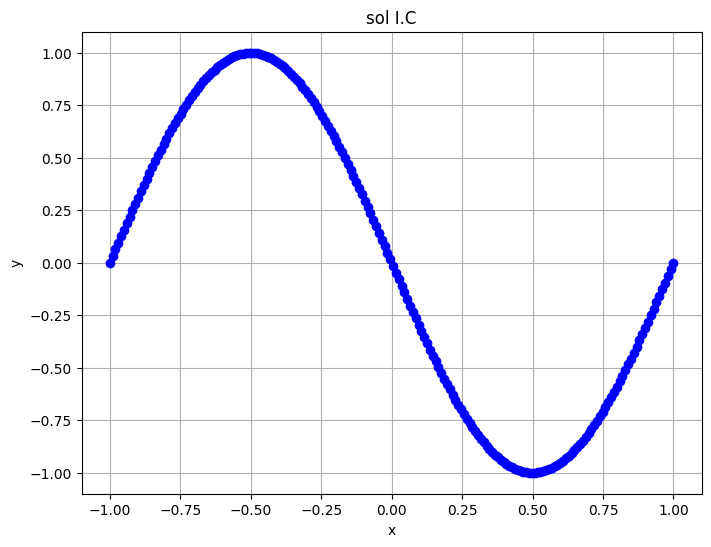

In [7]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.title("sol I.C")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

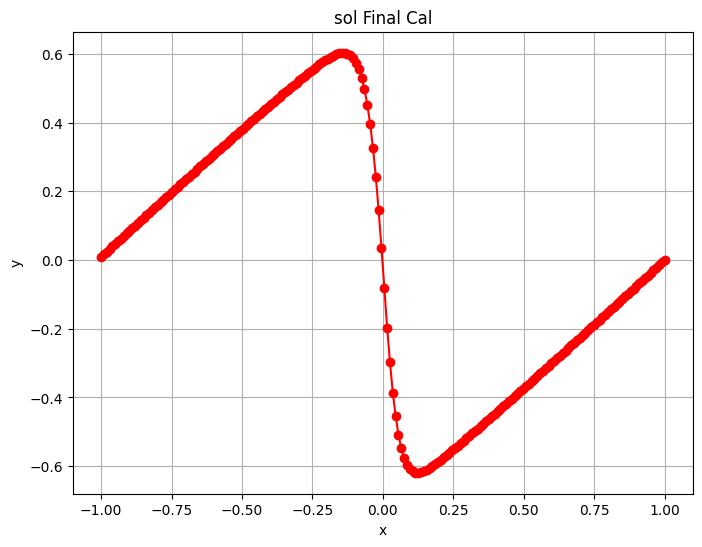

In [8]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[-1], '-o', color = 'r')
plt.title("sol Final Cal")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

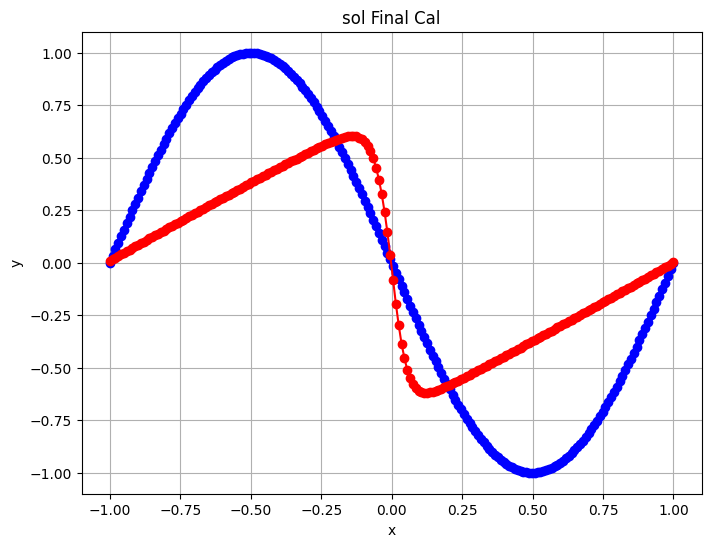

In [9]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.plot(x, uf[-1], '-o', color = 'r')
plt.title("sol Final Cal")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [10]:
tf = np.linspace(0, 1, nt)

In [11]:
xf = x

In [12]:
tf_tensor = torch.tensor(tf, dtype=torch.float32)
xf_tensor = torch.tensor(xf, dtype=torch.float32)
print(len(tf_tensor))
print(len(xf_tensor))

combined_tensor_x_train = torch.empty( (len(tf)*len(xf), 2), dtype=torch.float32)

index = 0
for i in range(len(tf)):
    for j in range(len(xf)):
        combined_tensor_x_train[index][0] = xf_tensor[j]
        combined_tensor_x_train[index][1] = tf_tensor[i]
        index += 1

500
200


In [13]:
your_tensor = torch.tensor(uf, dtype=torch.float32)
flattened_tensor_y_train = your_tensor.view(-1)
flattened_tensor_y_train = flattened_tensor_y_train.unsqueeze(1)
print(flattened_tensor_y_train.shape)

torch.Size([100000, 1])


In [14]:
flattened_tensor_y_train


tensor([[ 1.2246e-16],
        [ 3.1569e-02],
        [ 6.3106e-02],
        ...,
        [-1.4358e-02],
        [-6.6555e-03],
        [ 1.0607e-03]])

# Inverse PINN

In [15]:
lamda_value = 2.0
print("the real value=", viscosity_coeff, "Our I-PINNs value=", lamda_value)

the real value= 0.02 Our I-PINNs value= 2.0


In [16]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 30),
            nn.Tanh(),
            nn.Linear(30, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
            nn.Tanh(),
        )
    def forward(self, x):
        out = self.net(x)
        return out

In [17]:
class Net:
    def __init__(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = device
        # Point ##############################################################
        self.lamda_value = torch.tensor([lamda_value], requires_grad=True).float().to(device)
        self.lamda_value = nn.Parameter(self.lamda_value) # lamda is Learning Targets
        ######################################################################
        self.model = NN().to(device)
        self.model.register_parameter('lamda_value', self.lamda_value)
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        ##################### Input the data #################################
        self.X_train = combined_tensor_x_train.to(device)
        self.y_train = flattened_tensor_y_train.to(device)
        ######################################################################

        self.X = self.X.to(device)
        self.X.requires_grad = True

        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)

        self.adam = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()

        ########################
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        ########################
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        du_dt = du_dX[:, 1]
        du_dX = du_dX[:, 0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph=True,
            retain_graph=True
        )[0]

        du_dXX = du_dXX[:, 0]
        lamda_pde = self.lamda_value
        loss_pde = self.criterion(du_dt + 1 * u.squeeze() * du_dX, lamda_pde*du_dXX )
        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print("iteration number=",self.iter, "    loss value =", loss.item(), "real mu=", viscosity_coeff, "IPINN lambda=", self.lamda_value.item())

        self.iter += 1
        return loss

    def train(self):
        self.model.train()
        for i in range(5000):
            self.adam.step(self.loss_func)
    def eval_(self):
        self.model.eval()

In [18]:
net = Net()
net.train()
net.model.eval()

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


iteration number= 100     loss value = 0.21195746958255768 real mu= 0.02 IPINN lambda= 1.903871774673462
iteration number= 200     loss value = 0.20025131106376648 real mu= 0.02 IPINN lambda= 1.8398346900939941
iteration number= 300     loss value = 0.1961667239665985 real mu= 0.02 IPINN lambda= 1.7791560888290405
iteration number= 400     loss value = 0.1930035650730133 real mu= 0.02 IPINN lambda= 1.7169939279556274
iteration number= 500     loss value = 0.19044937193393707 real mu= 0.02 IPINN lambda= 1.6491845846176147
iteration number= 600     loss value = 0.18788431584835052 real mu= 0.02 IPINN lambda= 1.576159954071045
iteration number= 700     loss value = 0.18582169711589813 real mu= 0.02 IPINN lambda= 1.5117452144622803
iteration number= 800     loss value = 0.18441349267959595 real mu= 0.02 IPINN lambda= 1.4632644653320312
iteration number= 900     loss value = 0.1833598017692566 real mu= 0.02 IPINN lambda= 1.4251550436019897
iteration number= 1000     loss value = 0.182527214

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=1, bias=True)
    (9): Tanh()
  )
)

# PINN

In [20]:
h = 0.01
k = 0.01
x = torch.arange(-1,1, h)
t = torch.arange(0,1, k)

X = torch.stack(torch.meshgrid(x, t)).reshape(2,-1).T
X = X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [21]:
y_pred_inverse = y_pred

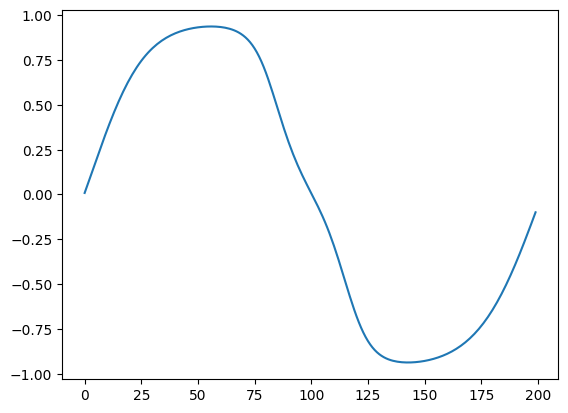

In [22]:
#I.C
plt.plot(y_pred_inverse[:,0])

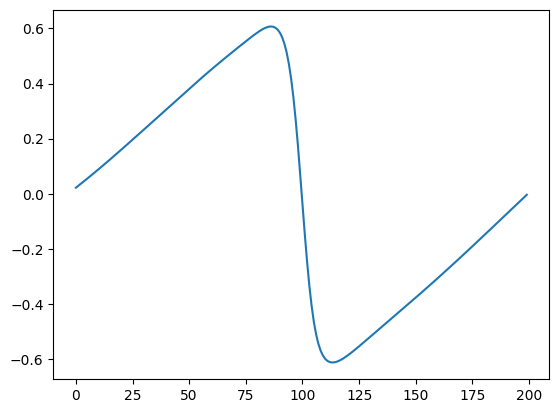

In [23]:
#Final.C
plt.plot(y_pred_inverse[:,-1])

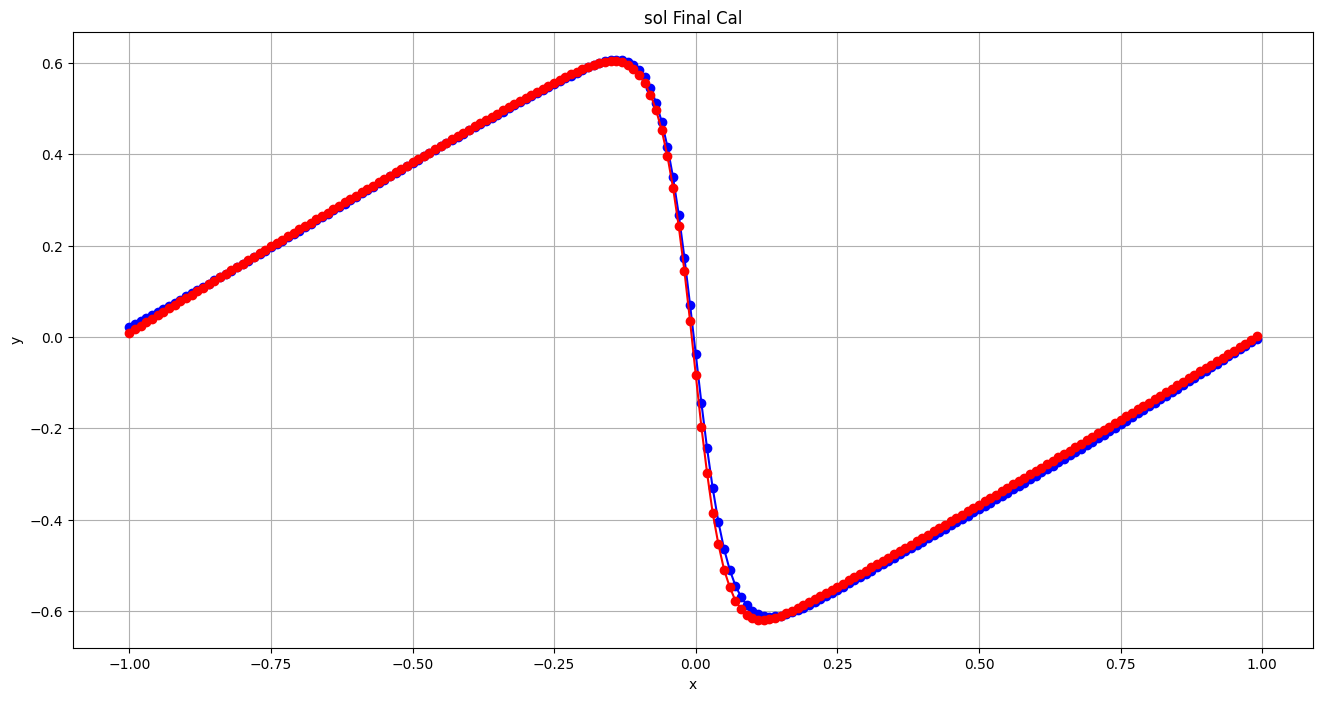

In [24]:
plt.figure(figsize=(16,8))
plt.plot(x, y_pred_inverse[:, -1], '-o', color = 'b') #I-PINN
plt.plot(x, uf[-1], '-o', color = 'r') # TVD
plt.title("sol Final Cal")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [25]:
sns.set_style('whitegrid')
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred_inverse,cmap='jet')
plt.show()